In [94]:
from common_functions import load_housing_data
import pandas as pd
PATH = "datasets/Titanic"

train_dataset = load_housing_data(PATH, "train.csv")
titanic_test = load_housing_data(PATH, "test.csv")

In [95]:
# Split the labels and the features
# X_train_prepared = X_train.drop("Survived", axis=1)
# y_train_labels = X_train["Survived"]

In [96]:
train_dataset.info()
# X_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [97]:
from sklearn.base import BaseEstimator, TransformerMixin
# Drop titanic objects
class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, features_names):
        self._features_names = features_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.drop(self._features_names, axis=1)
        return X
    

First of all, a good idea is to drop the columns of the name, the passengers id, the ticket and cabine.Afertward,  we 
have to encode several columns.
### pClass
- 1 = 1st
- 2 = 2nd
- 3 = 3rd

### Port of embarkation
- C = Cherbourg
- Q = Queenstown
- S = Southampton

### Sex
- Male
- Female

We have also to scale in a standard way the age, fare, SibSp and Parch.

In [98]:
train_dataset = train_dataset.dropna(axis=0, subset=["Embarked"])

In [99]:
# Split the labels and the features
X_train = train_dataset.drop("Survived", axis=1)
y_train = train_dataset["Survived"]

In [100]:
# Data cleaning
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

dropped_columns = ["Name", "PassengerId", "Ticket", "Cabin"]
categorical_features = ['Embarked', 'Sex', 'Pclass']
numeric_features = ["Age", "Fare", "SibSp", "Parch"]
dropped_features = ["Pclass", "Sex", "Embarked", "Age", "Fare"]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

dropping_transformer = Pipeline([
    ('dropping', FeatureDropper(dropped_columns))
])

col_transformer = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features),
        # ('drop', dropping_transformer, dropped_features)
    ]
)

prepare_data = Pipeline([
    ('preprocessing_dropping', FeatureDropper(dropped_columns)),
    ('col', col_transformer),
])
# union_pipeline = Pipeline([
#     ('feats', FeatureUnion([
#         ('ngram', )
#     ]))
# ])

X_train_pipeline = prepare_data.fit_transform(X_train)


In [101]:
# Convert to DataFrame
encoder_columns = ['C', 'Q', 'S', 'Female', 'Male', '1st', '2nd', '3rd', "Age", "Fare", "SibSp", "Parch"]
X_train_prepared = pd.DataFrame(data = X_train_pipeline, columns=encoder_columns)

In [102]:
# Concat the dataframe -> change to feature union
# X_train.reset_index(drop=True, inplace=True)
# X_train_transformed.reset_index(drop=True, inplace=True)
# X_train_transformed = pd.concat([X_train, X_train_transformed], axis=1)
# X_train_transformed

In [103]:
from sklearn import set_config
set_config(display='diagram')
prepare_data

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Pipeline(steps=[('preprocessing_dropping', FeatureDropper(features_names=None)),
                ('col',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked', 'Sex',
                                                   'Pclass']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch'])]))])

In [104]:
# Test set
# titanic_test.dropna(axis=0, subset=["Embarked"])
# X_test_prepared = prepare_data.fit_transform(titanic_test)
# X_test_prepared
# X_test_transformed = pd.DataFrame(data = X_test_prepared, columns=encoder_columns)
# X_test_transformed

Classifier

In [105]:
# SGD Classifier
from sklearn.linear_model import SGDClassifier

# y_label=1 means that the person survived 
y_train_survived = (y_train == 1)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_prepared, y_train_survived)


SGDClassifier(random_state=42)

In [106]:
some_people = X_train_prepared.iloc[[3]]
sgd_clf.predict(some_people)

array([ True])

Measuring Accuracy Using Cross-Validation

In [107]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train_prepared, y_train_survived, cv=5, scoring="accuracy")

array([0.80337079, 0.79775281, 0.75842697, 0.75842697, 0.81355932])

Confusion matrix

In [108]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Show the prediction for each rows
y_train_pred = cross_val_predict(sgd_clf, X_train_prepared, y_train_survived, cv=3)

confusion_matrix(y_train_survived, y_train_pred)

array([[466,  83],
       [131, 209]], dtype=int64)

In [109]:
from sklearn.metrics import precision_score, recall_score, f1_score

def display_scores(y_train, y_pred):
    print("Precision : ", precision_score(y_train, y_pred))
    print("Recall : ", recall_score(y_train, y_pred))
    print("f1 : ", f1_score(y_train, y_pred))

display_scores(y_train_survived, y_train_pred)



Precision :  0.7157534246575342
Recall :  0.6147058823529412
f1 :  0.6613924050632911


RandomForestClassifier

In [110]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train_prepared, y_train_survived)

RandomForestClassifier(random_state=42)

Measuring Accuracy Using Cross-Validation

In [111]:
from sklearn.model_selection import cross_val_score
cross_val_score(forest_clf, X_train_prepared, y_train_survived, cv=5, scoring="accuracy")

array([0.78651685, 0.79213483, 0.85393258, 0.76404494, 0.82485876])

Confusion matrix

In [112]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Show the prediction for each rows
y_train_pred = cross_val_predict(forest_clf, X_train_prepared, y_train_survived, cv=3)

confusion_matrix(y_train_survived, y_train_pred)
display_scores(y_train_survived, y_train_pred)

Precision :  0.7347560975609756
Recall :  0.7088235294117647
f1 :  0.721556886227545


In [113]:
# Get several values we can change in the forest_clf
forest_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [114]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap' : ['True', 'False'],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
    'n_estimators' :[3, 10, 30, 100, 300, 1000]
}

CV_rfc = GridSearchCV(estimator=forest_clf, param_grid=param_grid, cv= 5)

### Best parameters for the RandomForestClassifier
{'bootstrap': 'True',
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 30}

In [115]:
# CV_rfc.fit(X_train_prepared, y_train_survived)

In [116]:
# CV_rfc.best_params_

In [117]:
best_rfc = RandomForestClassifier(bootstrap=True, criterion='entropy', max_depth=7, max_features='auto', n_estimators=30)
best_rfc.fit(X_train_prepared, y_train_survived)
y_pred = best_rfc.predict(X_train_prepared)
display_scores(y_train_survived, y_pred)

Precision :  0.9358490566037736
Recall :  0.7294117647058823
f1 :  0.8198347107438018


Try to adjust the features

In [118]:
y_scores = cross_val_predict(sgd_clf, X_train_prepared, y_train_survived, cv=3, method="decision_function")

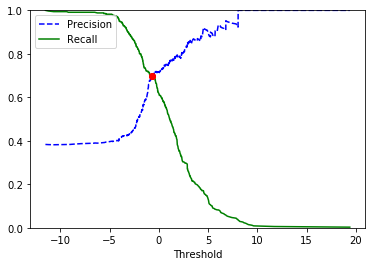

In [119]:
from sklearn.metrics import precision_recall_curve
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

precisions, recalls, thresholds = precision_recall_curve(y_train_survived, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    # Zoom on the curves
    # plt.xlim([-400, -200])
    # Intersection
    intersection = np.argwhere(np.diff(np.sign(precisions[:-1] - recalls[:-1]))).flatten()
    plt.plot(thresholds[intersection], precisions[:-1][intersection], 'ro')
    
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plt.show()


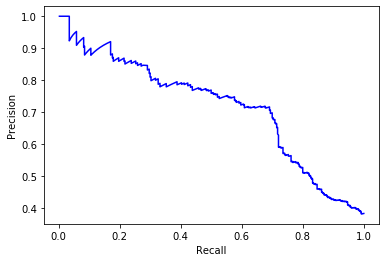

In [120]:
def plot_recall_vs_precision(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    
plot_recall_vs_precision(precisions, recalls)
# plt.show()



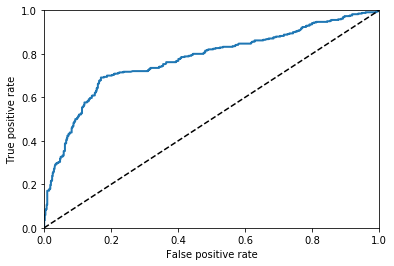

In [121]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_survived, y_scores)

def plot_roc_curve(fpr, trp, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
plot_roc_curve(fpr, tpr)
# plt.show()

In [122]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_pred, y_train_survived)

0.7791427546628408

Try to test the model

In [123]:
X_test = titanic_test.dropna(axis=0, subset=["Embarked"])
len(X_test)

418

In [124]:
X_test_prepared = prepare_data.fit_transform(X_test)


In [126]:
y_test = load_housing_data(PATH, "gender_submission.csv")
len(y_test)
y_test_survived = (y_test['Survived'] == 1)


In [128]:
# Use the best rfc model
y_test_pred = best_rfc.predict(X_test_prepared)
display_scores(y_test_survived, y_test_pred)



Precision :  0.9078014184397163
Recall :  0.8421052631578947
f1 :  0.8737201365187712


array([[253,  13],
       [ 24, 128]], dtype=int64)

In [129]:
confusion_matrix(y_test_survived, y_test_pred)



array([[253,  13],
       [ 24, 128]], dtype=int64)